In [ ]:
#| default_exp inference.core
#| default_cls_lvl 3

In [ ]:
#| export
from tsfast.datasets.core import extract_mean_std_from_dls
from tsfast.data.loader import reset_model_state
from tsfast.models.layers import NormalizedModel
import warnings
from tsfast.prediction.core import PredictionCallback
from fastai.learner import Learner
import numpy as np
import torch

In [ ]:
#| export
class InferenceWrapper:
    def __init__(self,
                 learner: Learner, # The trained fastai Learner object.
                 device: str | torch.device = 'cpu' # Device for inference ('cpu', 'cuda').
                ):
        if not isinstance(learner, Learner) or not hasattr(learner, 'model') or not hasattr(learner, 'dls'): raise TypeError("Input 'learner' must be a valid fastai Learner with model and dls.")
        self.device = torch.device(device)
        self.core_model = learner.model.to(self.device).eval() # Ensure model is on correct device and in eval mode
        self._pred_cb: PredictionCallback | None = next((cb for cb in learner.cbs if isinstance(cb, PredictionCallback) and hasattr(cb, 'norm') and cb.norm is not None), None) # Find the first valid PredictionCallback
        try:
            mean, std = extract_mean_std_from_dls(learner.dls) # Extract normalization stats applied last during training
            if mean is None or std is None: raise ValueError("Could not extract mean/std from learner.dls.")

            if self._pred_cb:
                mean = torch.cat((mean,self._pred_cb.norm.mean.to(mean.device)),dim=-1)
                std = torch.cat((std,self._pred_cb.norm.std.to(std.device)),dim=-1)

            self.norm_model = NormalizedModel(self.core_model, mean, std).to(self.device).eval() # Wrap core model with the main normalization
            self.expected_total_features = mean.shape[-1] # Store the feature dimension expected by the final normalization layer
        except Exception as e: raise RuntimeError(f"Failed to extract main normalization parameters from learner.dls: {e}")

    def _prepare_tensor(self, np_array: np.ndarray, name: str) -> torch.Tensor: # Converts numpy array to a 3D tensor [1, seq_len, features] on the correct device.
        if not isinstance(np_array, np.ndarray): raise TypeError(f"{name} must be a NumPy array.")
        if np_array.ndim == 1: np_array = np_array[None, :, None] # [seq_len] -> [1, seq_len, 1]
        elif np_array.ndim == 2: np_array = np_array[None, :, :] # [seq_len, features] -> [1, seq_len, features]
        elif np_array.ndim != 3 or np_array.shape[0] != 1: raise ValueError(f"{name} must be 1D, 2D, or 3D with batch_size=1. Got shape: {np_array.shape}")
        return torch.from_numpy(np_array).float().to(self.device)

    def _adjust_seq_len(self, tensor: torch.Tensor, target_len: int, name: str) -> torch.Tensor: # Adjusts sequence length (dim 1) of a [1, seq_len, features] tensor.
        current_len = tensor.shape[1]
        if current_len == target_len: return tensor
        if current_len < target_len: return torch.nn.functional.pad(tensor, (0, 0, 0, target_len - current_len)) # Pads dim 1 (sequence) on the right
        warnings.warn(f"Truncating {name} seq len from {current_len} to {target_len}.", UserWarning)
        return tensor[:, :target_len, :] # Truncate sequence dimension

    @torch.no_grad() # Disable gradients for inference
    def inference(self,
                  np_input: np.ndarray, # Input time series (u). Shape [seq_len], [seq_len, u_features], or [1, seq_len, u_features].
                  np_output_init: np.ndarray | None = None # Initial output series (y_init). Required if trained with PredictionCallback or in Dataloader Prediction mode. Defaults to None.
                 ) -> np.ndarray: # Prediction as numpy array. Shape: [seq_len, out_features].
        u_tensor = self._prepare_tensor(np_input, "np_input")
        input_seq_len = u_tensor.shape[1]
        y_init_tensor = self._prepare_tensor(np_output_init, "np_output_init") if np_output_init is not None else None
        
        final_input = None
        if self._pred_cb: # Mode: PredictionCallback Was Used During Training
            if y_init_tensor is None: raise ValueError("Model trained with PredictionCallback requires 'np_output_init'.")
            if input_seq_len - self._pred_cb.t_offset <= 0: raise ValueError(f"Input seq len ({input_seq_len}) too short for offset ({self._pred_cb.t_offset}).")
            if self._pred_cb.t_offset > 0:
                u_tensor = u_tensor[:, self._pred_cb.t_offset:, :] # Apply offset to u
                y_init_tensor = y_init_tensor[:, :-self._pred_cb.t_offset, :] # Adjust y length to match offset u
            y_init_tensor = self._adjust_seq_len(y_init_tensor, input_seq_len, "y_init") # Adjust y length to match u
            final_input = torch.cat((u_tensor, y_init_tensor), dim=-1)
        elif y_init_tensor is not None and u_tensor.shape[-1] > self.expected_total_features: # Mode: No PredCB, but y_init provided (Dataloader Prediction)
            y_init_tensor = self._adjust_seq_len(y_init_tensor, input_seq_len, "y_init") # Adjust y length to match u
            final_input = torch.cat((u_tensor, y_init_tensor), dim=-1)
        else: # Mode: No PredCB, no y_init provided (Simulation)
            final_input = u_tensor

        if final_input.shape[-1] != self.expected_total_features: raise ValueError(f"Prepared input features ({final_input.shape[-1]}) != expected ({self.expected_total_features}).")
        reset_model_state(self.core_model) # Reset stateful layers (RNNs, etc.) before running the model
        model_output = self.norm_model(final_input) # Apply main normalization and get model output
        output_tensor = model_output[0] if isinstance(model_output, tuple) else model_output # Handle potential tuple output
        if not isinstance(output_tensor, torch.Tensor): raise RuntimeError(f"Model output is not a tensor. Type: {type(output_tensor)}")
        return output_tensor.squeeze(0).cpu().numpy() # Squeeze batch dim, move to CPU, convert to numpy

    def __call__(self, np_input: np.ndarray, np_output_init: np.ndarray | None = None) -> np.ndarray: # Convenience method to call inference directly.
        return self.inference(np_input, np_output_init)

In [ ]:
from tsfast.datasets.core import create_dls_test
from tsfast.models import RNNLearner
from tsfast.prediction import FranSysLearner

In [ ]:
dls = create_dls_test().cpu()
lrn = RNNLearner(dls)
model = InferenceWrapper(lrn)

In [ ]:
model(np.random.randn(100, 1)).shape

(100, 1)

In [ ]:
model(np.random.randn(100)).shape

(100, 1)

In [ ]:
model(np.random.randn(1,100,1)).shape

(100, 1)

In [ ]:
lrn = FranSysLearner(dls.cpu(),10,attach_output=True)
model = InferenceWrapper(lrn)

In [ ]:
#check output of model equivalent to lrn
y_pred,y_true =lrn.get_preds(ds_idx=-1)

In [ ]:
from tsfast.data import hdf_extract_sequence

In [ ]:
#get raw sequence from test set without normalization
test_path=dls[-1].items[0]['path']
u = hdf_extract_sequence(test_path,['u'])
y = hdf_extract_sequence(test_path,['y'])

In [ ]:
from matplotlib import pyplot as plt

(0.0, 100.0)

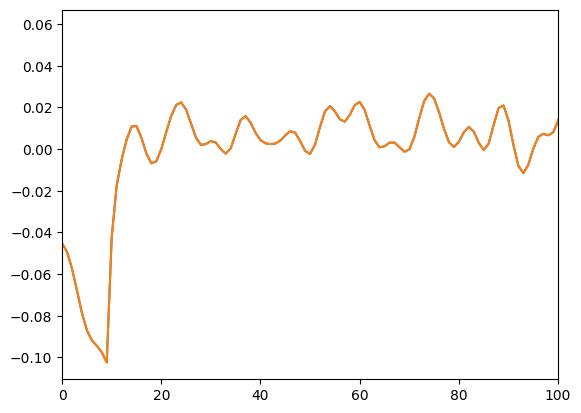

In [ ]:
plt.plot(y_pred[0])
plt.plot(model(u,y))
plt.xlim(0,100)

In [ ]:
model(np.random.randn(100, 1),np.random.randn(100, 1)).shape

(100, 1)

In [ ]:
lrn = FranSysLearner(dls,10,attach_output=False)
model = InferenceWrapper(lrn)

In [ ]:
lrn = FranSysLearner(dls,10,attach_output=True)
model = InferenceWrapper(lrn)
model(np.random.randn(100, 1),np.random.randn(10, 1)).shape

(100, 1)

In [ ]:
#| include: false
import nbdev; nbdev.nbdev_export()